# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

#### Подключаем Google Drive и задаём корневую папку проекта

In [ ]:
#  ===== 0. Подключаем Google Drive и задаём корневую папку проекта =====
from pathlib import Path
import sys, os

try:
    # вариант Colab
    from google.colab import drive
    drive.mount('/content/drive')
    GDRIVE_ROOT = Path("/content/drive/MyDrive")
except (ModuleNotFoundError, ValueError):
    # локальный Jupyter + Google Drive for desktop
    #   (проверьте, где именно у вас смонтирован «Мой Диск»)
    possible = [
        Path.home() / "Google Drive",
        Path.home() / "Мой диск"            # рус. версия клиента
    ]
    GDRIVE_ROOT = next((p for p in possible if p.exists()), None)
    if GDRIVE_ROOT is None:
        sys.exit("Папка Google Drive не найдена. Проверьте путь.")

# ────────────────────────────────────────────────────────────────────────
PROJECT_DIR = GDRIVE_ROOT / "price_forecasting"
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

# Единая «точка входа» для остальных путей
ROOT                     = PROJECT_DIR
DATA                     = ROOT / "data"               # сырые и промежуточные датасеты
MODEL_READY              = DATA / "model_ready"
SPLITS_WF                = MODEL_READY / "splits_wf"
ARTIFACTS                = ROOT / "artifacts"          # модели, метрики, изображения
PLOTS                    = ARTIFACTS / "plots"
MODELS                   = ARTIFACTS / "models"
PREDICTIONS              = ARTIFACTS / "predictions"
METRICS                  = ARTIFACTS / "metrics"

for d in (DATA, MODEL_READY, SPLITS_WF, ARTIFACTS, PLOTS, MODELS, PREDICTIONS, METRICS):
    d.mkdir(parents=True, exist_ok=True)

print(f"Все файлы читаем/пишем в: {ROOT}")

Mounted at /content/drive
Все файлы читаем/пишем в: /content/drive/MyDrive/price_forecasting


In [ ]:
# ── Шаг-1. Чтение данных и мета-описания ─────────────────────
import pandas as pd, numpy as np, json

DF_PATH   = MODEL_READY / "dataset.parquet"
META_PATH = MODEL_READY / "features.json"

df   = pd.read_parquet(DF_PATH)
meta = json.load(open(META_PATH))

TARGET = meta["target_log"]          # лог-цена через 28 дней

print("Data shape :", df.shape)
print("Target col :", TARGET)

Data shape : (57473650, 50)
Target col : target_log


In [ ]:
# ── Шаг-2. Наивный прогноз t-28  + метрики ────────────
from sklearn.metrics import mean_squared_error
from datetime import datetime
import numpy as np

def smape(actual, forecast):
    return 100 * np.mean(
        np.abs(forecast - actual) /
        ((np.abs(actual) + np.abs(forecast)) / 2)
    )

HORIZON = 28
fold_results = []

for k in range(3):
    tr_idx = np.load(SPLITS_WF / f"wf_train_idx_k{k}.npy")
    vl_idx = np.load(SPLITS_WF / f"wf_val_idx_k{k}.npy")

    y_val  = df.loc[vl_idx, TARGET].values.astype("float32")
    y_pred = df.loc[vl_idx - HORIZON, TARGET].values.astype("float32")

    mse   = mean_squared_error(y_val, y_pred)   # только MSE
    rmse  = float(np.sqrt(mse))                 # берём корень вручную
    s_mp  = float(smape(y_val, y_pred))

    np.save(PREDICTIONS / f"preds_naive_k{k}.npy", y_pred)

    fold_results.append({"fold": k, "rmse_log": rmse, "smape": s_mp})
    print(f"fold {k}: RMSE={rmse:.4f} | sMAPE={s_mp:.2f}%")


fold 0: RMSE=0.5483 | sMAPE=34.23%
fold 1: RMSE=0.6914 | sMAPE=36.89%
fold 2: RMSE=0.7251 | sMAPE=37.29%


In [ ]:
# ── Шаг-3. Сохраняем правило «наивного» предсказания ─────────
import pickle

naive_descr = {
    "type"     : "naive_seasonal",
    "shift"    : HORIZON,
    "target"   : TARGET,
    "created"  : datetime.now().isoformat(timespec="seconds")
}

with open(MODELS / "naive_model.pkl", "wb") as fp:
    pickle.dump(naive_descr, fp)

print("✔ Модель-описание naive_model.pkl сохранено")


✔ Модель-описание naive_model.pkl сохранено


In [ ]:
# ── Шаг-4. Записываем метрики в JSON ─────────────────────────
import json, pathlib

metrics_path = METRICS / "metrics_naive.json"
json.dump(
    {"timestamp": datetime.now().isoformat(timespec="seconds"),
     "results"  : fold_results},
    open(metrics_path, "w"),
    indent=2
)

print("✔ Метрики сохранены →", metrics_path.relative_to(PROJECT_DIR))


✔ Метрики сохранены → artifacts/metrics/metrics_naive.json


In [ ]:
import json, pandas as pd

metrics_path = METRICS / "metrics_naive.json"
naive_report = json.load(open(metrics_path))

df_metrics = pd.DataFrame(naive_report["results"])
df_metrics["rmse_log"] = df_metrics["rmse_log"].round(4)
df_metrics["smape"]    = df_metrics["smape"].round(2)

display(df_metrics.style.set_caption("Naïve Seasonal – метрики по фолдам"))
print("\nСредние значения 3-х фолдов:")
print(df_metrics[["rmse_log","smape"]].mean().rename({"rmse_log":"RMSE(log)",
                                                      "smape":"sMAPE(%)"}))


,fold,rmse_log,smape
0,0,0.548300,34.230000
1,1,0.691400,36.890000
2,2,0.725100,37.290000



Средние значения 3-х фолдов:
RMSE(log)     0.654933
sMAPE(%)     36.136667
dtype: float64


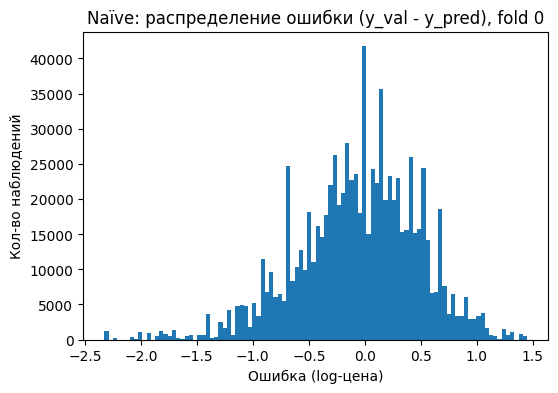

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# загрузим предсказания и реальное y для k0
y_val_k0  = df.loc[np.load(SPLITS_WF/'wf_val_idx_k0.npy'), TARGET].values
y_pred_k0 = np.load(PREDICTIONS/'preds_naive_k0.npy')

plt.figure(figsize=(6,4))
plt.hist(y_val_k0 - y_pred_k0, bins=100)
plt.title("Naïve: распределение ошибки (y_val - y_pred), fold 0")
plt.xlabel("Ошибка (log-цена)")
plt.ylabel("Кол-во наблюдений")
plt.show()


Пик распределения ошибки около нуля, но «толстый» правый хвост > 0.5 говорит, что часть SKU заметно дорожает за 4 недели — простое повторение t-28 тут промахивается.

Эти значения станут ориентиром: любая следующая модель должна выбить RMSE < 0.55 и sMAPE < 34 % хотя бы на первом фолде, чтобы считаться улучшением.